In [1]:
# !set CUDA_VISIBLE_DEVICES=""
# !set CUDA_LAUNCH_BLOCKING=1

In [1]:
import pandas as pd
import sklearn
import os
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader
os.environ["KERAS_BACKEND"] = 'torch'
# os.environ["CUDA_VISIBLE_DEVICES"] = "" 
import keras

In [2]:
np.random.seed(42)#10
torch.manual_seed(42)#42

In [2]:
# torch.backends.cudnn.enabled = False
# torch.cuda.is_available = lambda: False
# torch.device("cpu")

device(type='cpu')

In [3]:
torch.cuda.is_available()

True

In [44]:
df = pd.read_csv('pmi-data.csv')
test_df = df.loc[df['split'] == 'test']
df = df.loc[df['split'] == 'train']

In [4]:
%%html
<h1>1. Datasets and Dataloaders</h1>

In [45]:
train_data, valid_data = sklearn.model_selection.train_test_split(df, test_size=0.25, shuffle=True, random_state=120)

In [46]:
minmax_scaler = sklearn.preprocessing.MinMaxScaler()
# train_data[['age', 'avg_glucose_level', 'bmi']] = minmax_scaler.fit_transform(train_data[['age', 'avg_glucose_level', 'bmi']])
# valid_data[['age', 'avg_glucose_level', 'bmi']] = minmax_scaler.transform(valid_data[['age', 'avg_glucose_level', 'bmi']])

In [48]:
class StrokeDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.labels = data['stroke']
        self.samples = data.drop(columns=['stroke', 'id', 'split'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.samples.iloc[idx].values), torch.tensor(self.labels.iloc[idx])

In [50]:
train_dataloader = DataLoader(StrokeDataset(train_data), batch_size=32, shuffle=True)
valid_dataloader = DataLoader(StrokeDataset(valid_data))

In [9]:
%%html
<h3>I think shuffling is a good idea because if we take a look at the pmi-data.csv we can see that all the cases with stroke=1 come first in the csv so that means if we didnt shuffle, all of them would be chosen for the training and none would be left for the testing</h3>

In [10]:
%%html
<h1>2. Model</h1>

In [116]:
import torch.nn.functional as F
class Model(torch.nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.l1 = torch.nn.Linear(in_size, 32)
        self.l2 = torch.nn.Linear(32, 16)
        self.l3 = torch.nn.Linear(16, 16)
        self.l4 = torch.nn.Linear(16, 16)
        # self.l5 = torch.nn.Linear(8, 8)
        # self.l6 = torch.nn.Linear(8, 8)
        # self.l7 = torch.nn.Linear(8, 8)
        # self.l8 = torch.nn.Linear(8, 16)
        # self.l9 = torch.nn.Linear(16, 16)
        # self.l10 = torch.nn.Linear(16, 16)
        # self.l11 = torch.nn.Linear(16, 8)
        self.l12 = torch.nn.Linear(16, out_size)

        self.dropout = torch.nn.Dropout(0.3)

        # torch.nn.init.xavier_uniform_(self.l1.weight)
        # torch.nn.init.xavier_uniform_(self.l2.weight)
        # torch.nn.init.xavier_uniform_(self.l3.weight)
        # torch.nn.init.xavier_uniform_(self.l4.weight)
        # torch.nn.init.xavier_uniform_(self.l5.weight)
        # # torch.nn.init.xavier_uniform_(self.l6.weight)
        # # torch.nn.init.xavier_uniform_(self.l7.weight)
        # # torch.nn.init.xavier_uniform_(self.l8.weight)
        # # torch.nn.init.xavier_uniform_(self.l9.weight)
        # # torch.nn.init.xavier_uniform_(self.l10.weight)
        # # torch.nn.init.xavier_uniform_(self.l11.weight)
        # torch.nn.init.xavier_uniform_(self.l12.weight)
    def forward(self, x):
        x = F.relu(self.l1(x))
        # x = self.dropout(x)
        x = F.relu(self.l2(x))
        # x = self.dropout(x)
        x = F.relu(self.l3(x))
        # x = self.dropout(x)
        x = F.relu(self.l4(x))
        # x = self.dropout(x)
        # x = F.relu(self.l5(x))
        # x = F.relu(self.l6(x))
        # x = F.relu(self.l7(x))
        # x = F.relu(self.l8(x))
        # x = F.relu(self.l9(x))
        # x = F.relu(self.l10(x))
        # x = F.relu(self.l11(x))
        x = self.l12(x)
        return x.squeeze()

def get_y_pred_y_true_valid_loss(model, threshold = 0.5, return_probs = False):
    y_pred = []
    y_true = []
    probs = []
    valid_loss = 0
    with torch.no_grad():
        for i, data in enumerate(valid_dataloader, 0):
            features, labels = data
            y_true.append(labels[0])
            outputs = model.forward(features)
            
            probs.append(torch.sigmoid(outputs).cpu().numpy())
            
            loss = loss_fn(outputs, labels[0].float())
            valid_loss += loss.item()
            y_pred.append((torch.sigmoid(outputs) > threshold).int())
            
    if return_probs == True:
        return np.array(probs)
        
    return y_pred, y_true, valid_loss

In [108]:
model = Model(10, 1)

In [13]:
# for param in model.parameters():
#     print(param)

In [109]:
%%html
<h1>3. Optimizer and Loss function</h1>

In [109]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [15]:
%%html
<h1>4. Training </h1>

In [117]:
N_EPOCHS = 50

best_acc = 0

hist_train_loss = []
hist_valid_loss = []
hist_accuracy = []

for epoch in range(N_EPOCHS):
    model.train()
    train_loss = 0
    valid_loss = 0
    for i, data in enumerate(train_dataloader, 0):
        features, labels = data
        
        optimizer.zero_grad()

        outputs = model(features).squeeze()
        #y_true = torch.tensor(labels).to(torch.float)
        loss = loss_fn(outputs, labels.float())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    y_pred, y_true, valid_loss = get_y_pred_y_true_valid_loss(model)

    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    print(f'Epoch {epoch}, accuracy: {accuracy}, train_loss={train_loss / len(train_dataloader)}, valid_loss={valid_loss / len(valid_dataloader)}')
    if accuracy > best_acc:
        torch.save(model.state_dict(), 'best_unbalanced_accuracy')
        best_acc = accuracy

    hist_train_loss.append(train_loss)
    hist_valid_loss.append(valid_loss)
    hist_accuracy.append(accuracy)

Epoch 0, accuracy: 0.9565217391304348, train_loss=0.21828945653874482, valid_loss=0.17258251482440579
Epoch 1, accuracy: 0.9565217391304348, train_loss=0.2120573106986373, valid_loss=0.16923764260253263
Epoch 2, accuracy: 0.9565217391304348, train_loss=0.2174660935997963, valid_loss=0.17639635221152286
Epoch 3, accuracy: 0.9565217391304348, train_loss=0.2043976609720223, valid_loss=0.1689229388558012
Epoch 4, accuracy: 0.9565217391304348, train_loss=0.2056535426249255, valid_loss=0.16797497705523798
Epoch 5, accuracy: 0.9565217391304348, train_loss=0.20347899537700326, valid_loss=0.16539860273310378
Epoch 6, accuracy: 0.9565217391304348, train_loss=0.20492638330628624, valid_loss=0.16742120651844342
Epoch 7, accuracy: 0.9565217391304348, train_loss=0.20551977395566542, valid_loss=0.1643024466482486
Epoch 8, accuracy: 0.9565217391304348, train_loss=0.19933092694229154, valid_loss=0.16780010547076168
Epoch 9, accuracy: 0.9565217391304348, train_loss=0.20071505738505677, valid_loss=0.1630

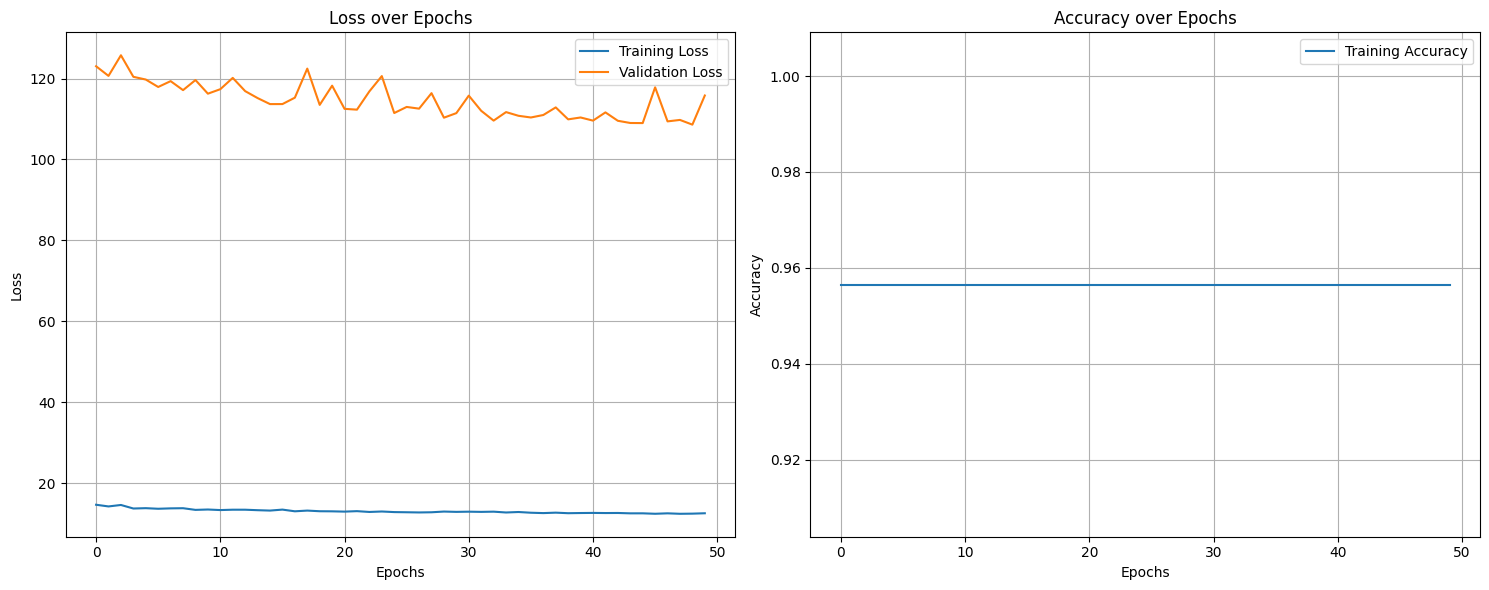

In [118]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(hist_train_loss, label='Training Loss')
plt.plot(hist_valid_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist_accuracy, label='Training Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [278]:
%%html
<h1>5. Evaluation</h1>

In [113]:
model.load_state_dict(torch.load('best_unbalanced_accuracy'))
y_pred, y_true, _ = get_y_pred_y_true_valid_loss(model)

Precision: 0.0
Recall: 0.0
F1_score: 0.0


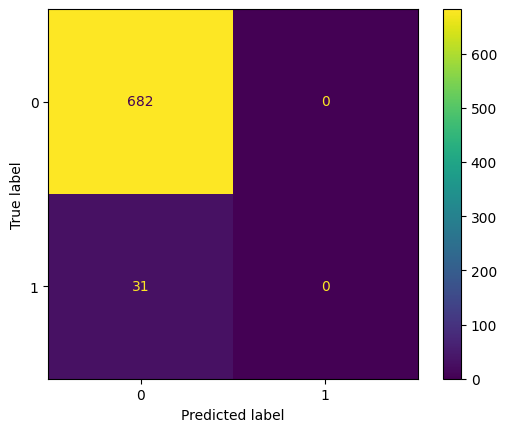

In [114]:
conf_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)
recall = sklearn.metrics.recall_score(y_true, y_pred,zero_division=0)
f1_score = sklearn.metrics.f1_score(y_true, y_pred,zero_division=0)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1_score: {f1_score}')
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix).plot()

In [115]:
%%html
<h1>6. Balance the training data distribution</h1>

In [132]:
model = Model(10, 1)
pos_weight = torch.tensor(train_data['stroke'].loc[train_data.stroke == 0].count() / train_data['stroke'].loc[train_data.stroke == 1].count())
optimizer = torch.optim.Adam(model.parameters(), lr=0.00007)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [53]:
pos_weight

tensor(16.5328, dtype=torch.float64)

In [172]:
y_tiny

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [133]:
N_EPOCHS = 100

best_f1_score = -1

hist_train_loss = []
hist_valid_loss = []

hist_accuracy = []
hist_precision = []
hist_recall = []
hist_f1_score = []

for epoch in range(N_EPOCHS):
    train_loss = 0
    valid_loss = 0
    model.train()
    for i, data in enumerate(train_dataloader, 0):
        features, labels = data
        
        optimizer.zero_grad()

        outputs = model(features).squeeze()
        #y_true = torch.tensor(labels).to(torch.float)
        loss = loss_fn(outputs, labels.float())
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    y_pred, y_true, valid_loss = get_y_pred_y_true_valid_loss(model)

    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    f1_score = sklearn.metrics.f1_score(y_true, y_pred, zero_division=0)
    recall = sklearn.metrics.recall_score(y_true, y_pred, zero_division=0)
    precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)

    hist_f1_score.append(f1_score)
    hist_recall.append(recall)
    hist_precision.append(precision)
    
    print(f'Epoch {epoch}, accuracy: {accuracy}, train_loss={train_loss / len(train_dataloader)}, valid_loss={valid_loss / len(valid_dataloader)}, f1_score={f1_score}, recall={recall}, precision={precision}, {"*" if (f1_score > best_f1_score) else None}')
    if f1_score > best_f1_score:
        torch.save(model.state_dict(), 'best_balanced_f1')
        best_f1_score = f1_score

    hist_train_loss.append(train_loss / len(train_dataloader))
    hist_valid_loss.append(valid_loss / len(valid_dataloader))
    hist_accuracy.append(accuracy)

Epoch 0, accuracy: 0.6437587657784011, train_loss=1.3065939714659507, valid_loss=1.1441767056894503, f1_score=0.11805555555555555, recall=0.5483870967741935, precision=0.06614785992217899, *
Epoch 1, accuracy: 0.31837307152875177, train_loss=1.2593645150981732, valid_loss=1.134448410585251, f1_score=0.10661764705882353, recall=0.9354838709677419, precision=0.056530214424951264, None
Epoch 2, accuracy: 0.394109396914446, train_loss=1.2439347763559712, valid_loss=1.12002152689376, f1_score=0.12195121951219512, recall=0.967741935483871, precision=0.0650759219088937, *
Epoch 3, accuracy: 0.41374474053295934, train_loss=1.2341852463893037, valid_loss=1.1122269013486437, f1_score=0.12552301255230125, recall=0.967741935483871, precision=0.06711409395973154, *
Epoch 4, accuracy: 0.42496493688639553, train_loss=1.221138382135932, valid_loss=1.104583530489559, f1_score=0.13135593220338984, recall=1.0, precision=0.07029478458049887, *
Epoch 5, accuracy: 0.4992987377279102, train_loss=1.2129410149

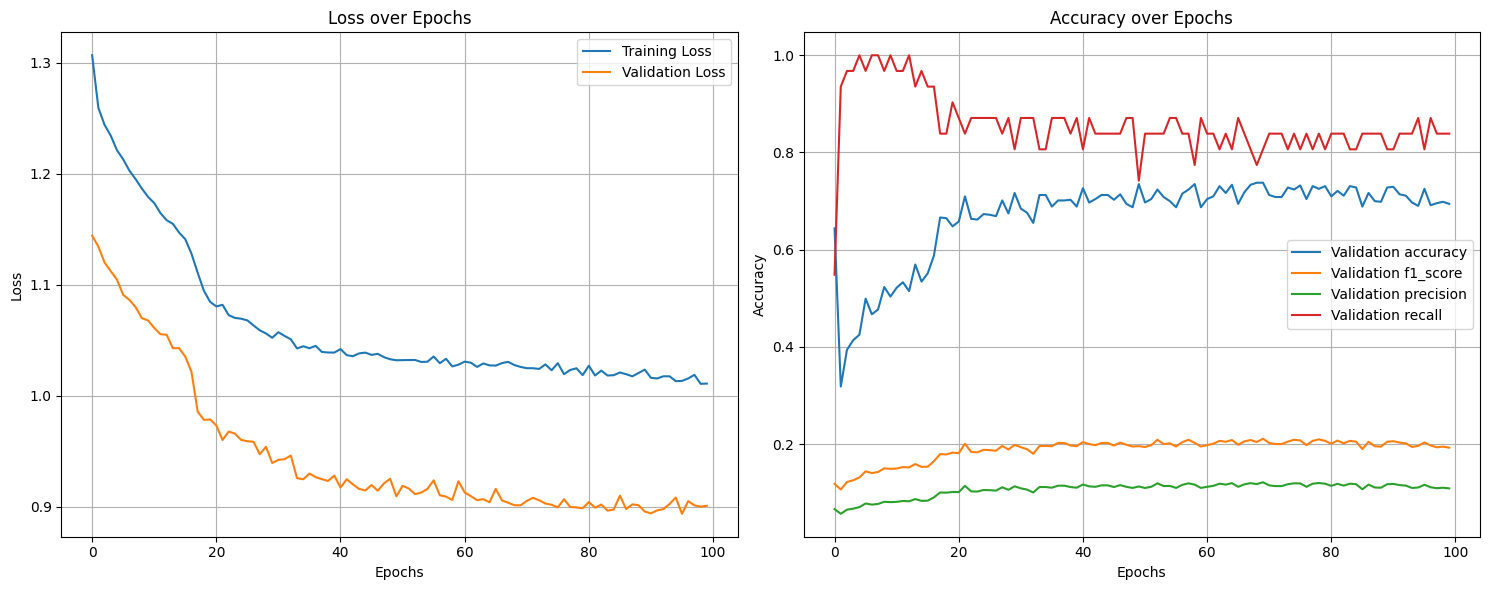

In [135]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(hist_train_loss, label='Training Loss')
plt.plot(hist_valid_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist_accuracy, label='Validation accuracy')
plt.plot(hist_f1_score, label='Validation f1_score')
plt.plot(hist_precision, label='Validation precision')
plt.plot(hist_recall, label='Validation recall')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Precision: 0.12135922330097088
Recall: 0.8064516129032258
F1_score: 0.2109704641350211


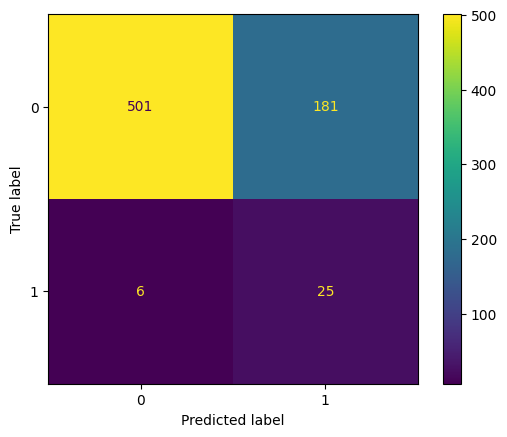

In [136]:
model.load_state_dict(torch.load('best_balanced_f1'))
y_pred, y_true, _ = get_y_pred_y_true_valid_loss(model)
        
conf_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)
recall = sklearn.metrics.recall_score(y_true, y_pred)
f1_score = sklearn.metrics.f1_score(y_true, y_pred)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1_score: {f1_score}')
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix).plot()

In [288]:
%%html
<h1>7. Focal Loss</h1>

In [98]:
class BinaryFocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = torch.nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        BCE_loss = self.bce(inputs, targets)
        pt = torch.exp(-BCE_loss)  # pt = p if target=1, else 1-p
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        F_loss = alpha_t * (1 - pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

In [103]:
model = Model(10, 1)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = BinaryFocalLoss(alpha=0.5, gamma=2)

In [104]:
N_EPOCHS = 30

best_f1_score = 0

hist_train_loss = []
hist_valid_loss = []

hist_accuracy = []
hist_precision = []
hist_recall = []
hist_f1_score = []

for epoch in range(N_EPOCHS):
    train_loss = 0
    valid_loss = 0
    
    for i, data in enumerate(train_dataloader, 0):
        features, labels = data
        
        optimizer.zero_grad()

        outputs = model(features).squeeze()
        #y_true = torch.tensor(labels).to(torch.float)
        loss = loss_fn(outputs, labels.float())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    y_pred, y_true, _ = get_y_pred_y_true_valid_loss(model)

    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    f1_score = sklearn.metrics.f1_score(y_true, y_pred, zero_division=0)
    recall = sklearn.metrics.recall_score(y_true, y_pred, zero_division=0)
    precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)

    hist_f1_score.append(f1_score)
    hist_recall.append(recall)
    hist_precision.append(precision)
    
    print(f'Epoch {epoch}, accuracy: {accuracy}, train_loss={train_loss / len(train_dataloader)}, valid_loss={valid_loss / len(valid_dataloader)}, f1_score={f1_score}, recall={recall}, precision={precision}, {"*" if (f1_score > best_f1_score) else None}')
    if f1_score > best_f1_score:
        torch.save(model.state_dict(), 'best_balanced_f1_focal_loss')
        best_f1_score = f1_score

    hist_train_loss.append(train_loss)
    hist_valid_loss.append(valid_loss)
    hist_accuracy.append(accuracy)

Epoch 0, accuracy: 0.9565217391304348, train_loss=0.04628160680685915, valid_loss=0.0, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 1, accuracy: 0.9565217391304348, train_loss=0.035722698196212745, valid_loss=0.0, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 2, accuracy: 0.9565217391304348, train_loss=0.0331452568687165, valid_loss=0.0, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 3, accuracy: 0.9565217391304348, train_loss=0.03096437630062895, valid_loss=0.0, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 4, accuracy: 0.9565217391304348, train_loss=0.030213004325641626, valid_loss=0.0, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 5, accuracy: 0.9565217391304348, train_loss=0.029521521563127415, valid_loss=0.0, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 6, accuracy: 0.9565217391304348, train_loss=0.0298899505912924, valid_loss=0.0, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 7, accuracy: 0.9565217391304348, train_loss=0.0285398368654188

Precision: 0.03940886699507389
Recall: 0.7741935483870968
F1_score: 0.075


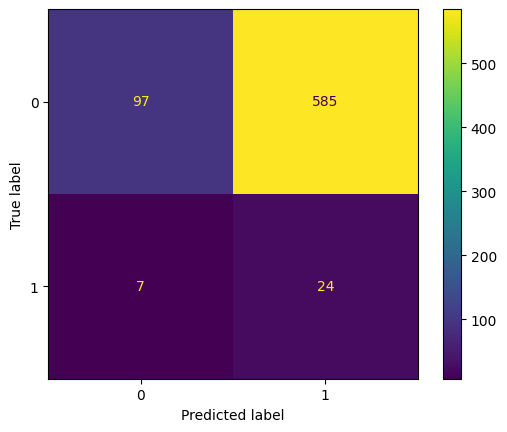

In [105]:
model =  Model(10, 1)
model.load_state_dict(torch.load('best_balanced_f1_focal_loss'))
y_pred, y_true, _ = get_y_pred_y_true_valid_loss(model)
        
conf_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)
recall = sklearn.metrics.recall_score(y_true, y_pred)
f1_score = sklearn.metrics.f1_score(y_true, y_pred)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1_score: {f1_score}')
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix).plot()

In [293]:
%%html
<h1>8. Inspecting model outputs. NOT DONE YET</h1>

In [137]:
model_unbalanced_accuracy = Model(10, 1)
model_unbalanced_accuracy.load_state_dict(torch.load('best_unbalanced_accuracy'))

model_balanced_f1 = Model(10, 1)
model_balanced_f1.load_state_dict(torch.load('best_balanced_f1'))

model_balanced_f1_focal = Model(10, 1)
model_balanced_f1_focal.load_state_dict(torch.load('best_balanced_f1_focal_loss'))

<All keys matched successfully>

In [138]:
def probabilities(model):
    probs = []
    with torch.no_grad():
        for data, label in valid_dataloader:
            if label == 0:
                continue
            logits = model(data)
            probs.append(torch.sigmoid(logits))        
    return np.array(probs)

vals_model_unbalanced_accuracy = get_y_pred_y_true_valid_loss(model_unbalanced_accuracy, return_probs=True)
vals_model_balanced_f1 = get_y_pred_y_true_valid_loss(model_balanced_f1, return_probs=True)
vals_model_f1_focal = get_y_pred_y_true_valid_loss(model_balanced_f1_focal, return_probs=True)

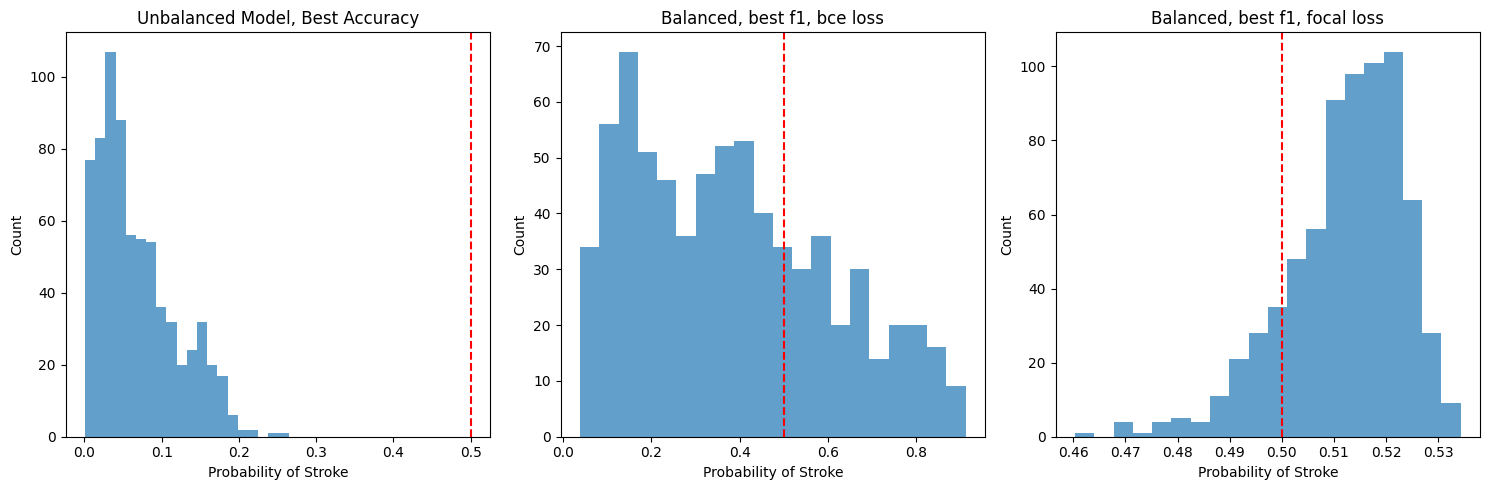

In [150]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(vals_model_unbalanced_accuracy, bins=20, alpha=0.7)
plt.axvline(x=0.5, color='r', linestyle='--')
plt.xlabel('Probability of Stroke')
plt.ylabel('Count')
plt.title('Unbalanced Model, Best Accuracy')

plt.subplot(1, 3, 2)
plt.hist(vals_model_balanced_f1, bins=20, alpha=0.7)
plt.axvline(x=0.5, color='r', linestyle='--')
plt.xlabel('Probability of Stroke')
plt.ylabel('Count')
plt.title('Balanced, best f1, bce loss')

plt.subplot(1, 3, 3)
plt.hist(vals_model_f1_focal, bins=20, alpha=0.7)
plt.axvline(x=0.5, color='r', linestyle='--')
plt.xlabel('Probability of Stroke')
plt.ylabel('Count')
plt.title('Balanced, best f1, focal loss')

plt.tight_layout()
plt.show()

In [155]:
%%html
<h3>The model trained with focal loss 'focuses' more on predicting the probability of stroke = true</h3>

In [298]:
%%html
<h1>9. Beyond default thresholds</h1>

In [146]:
def get_f1_score_models(threshold):
    f1_scores_model_unbalanced_accuracy = None
    f1_scores_model_balanced_f1 = None
    f1_scores_model_balanced_f1_focal = None

    y_pred_model_unbalanced_accuracy = []
    y_pred_model_balanced_f1 = []
    y_pred_model_balanced_f1_focal = []
    y_true = []
    
    y_pred_model_unbalanced_accuracy, y_true_1, _ = get_y_pred_y_true_valid_loss(model_unbalanced_accuracy, threshold)
    y_pred_model_balanced_f1, y_true_2, _ = get_y_pred_y_true_valid_loss(model_balanced_f1, threshold)
    y_pred_model_balanced_f1_focal, y_true_3, _ = get_y_pred_y_true_valid_loss(model_balanced_f1_focal, threshold)

    f1_scores_model_unbalanced_accuracy = sklearn.metrics.f1_score(y_true_1, y_pred_model_unbalanced_accuracy)
    f1_scores_model_balanced_f1 = sklearn.metrics.f1_score(y_true_2, y_pred_model_balanced_f1)
    f1_scores_model_balanced_f1_focal = sklearn.metrics.f1_score(y_true_3, y_pred_model_balanced_f1_focal)

    return f1_scores_model_unbalanced_accuracy, f1_scores_model_balanced_f1, f1_scores_model_balanced_f1_focal

In [148]:
history_thresholds = []
maximum = 0
for threshold in np.arange(0.25, 0.76, 0.01):
    history_thresholds.append(get_f1_score_models(threshold))
    maximum = max(maximum, max(history_thresholds[-1]))

In [61]:
%%html
<h1>10. Threshold sensitivity</h1>

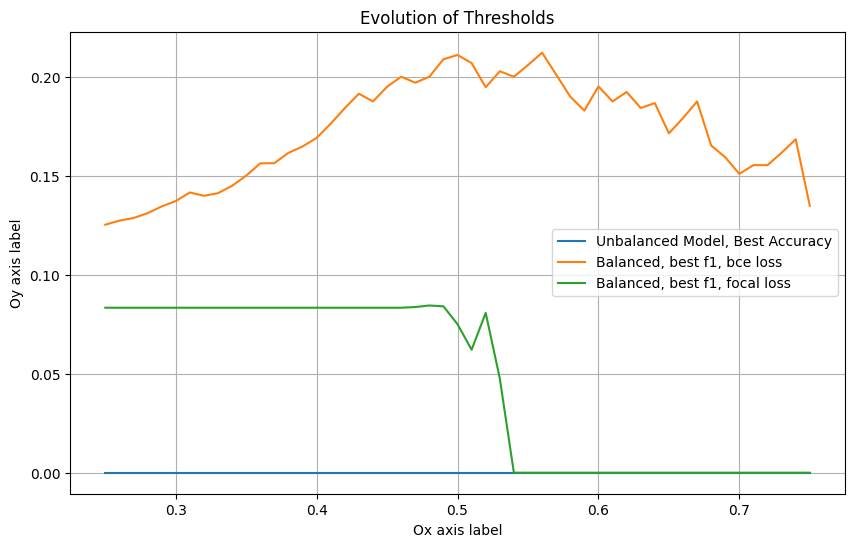

In [149]:
x = np.arange(0.25, 0.76, 0.01)

a = [t[0] for t in history_thresholds]
b = [t[1] for t in history_thresholds]
c = [t[2] for t in history_thresholds]

plt.figure(figsize=(10, 6))
plt.plot(x, a, label='Unbalanced Model, Best Accuracy')
plt.plot(x, b, label='Balanced, best f1, bce loss')
plt.plot(x, c, label='Balanced, best f1, focal loss')

plt.xlabel('Ox axis label')
plt.ylabel('Oy axis label')
plt.title('Evolution of Thresholds')
plt.legend()
plt.grid(True)
plt.show()

In [157]:
print(f'Best f1 validation score is {maximum}')

Best f1 validation score is 0.21212121212121213
